In [1]:
import netsquid as ns
from netsquid.nodes import DirectConnection, Node
from netsquid.components import FibreDelayModel, FibreLossModel, QuantumChannel, Message
from netsquid.components import DepolarNoiseModel, DephaseNoiseModel
from netsquid.protocols import NodeProtocol


In [ ]:
class SymmetricDirectConnection(DirectConnection):
    def __init__(self, name, L: int, loss_model, delay_model, noise_model) -> None:
        modelDict = {
            "delay_model": delay_model,
            "quantum_noise_model": noise_model,
            "quantum_loss_model": loss_model,
        }
        abChannel = QuantumChannel("A->B", length=L, models=modelDict)
        baChannel = QuantumChannel("B->A", length=L, models=modelDict)
        super().__init__(name, abChannel, baChannel)

In [3]:
class SendProtocol(NodeProtocol):
    def __init__(self, node, stop_flag):
        super().__init__(node)
        self.qbitSent = 0
        self.stop_flag = stop_flag

    def run(self):
        port = self.node.ports["qubitIO"]
        while not self.stop_flag[0]:
            self.qbitSent += 1
            qubit_id = self.qbitSent

            qubit = ns.qubits.create_qubits(1)[0]
            msg = Message(items=[qubit], meta={"id": qubit_id})
            port.tx_output(msg)

            yield self.await_timer(1e6)


class ReceiveProtocol(NodeProtocol):
    def __init__(self, node, stop_flag):
        super().__init__(node)
        self.arrival_time = None
        self.stop_flag = stop_flag
        self.received_id = None
        self.fidelity = None

    def run(self):
        port = self.node.ports["qubitIO"]
        # Wait (yield) until input has arrived on our port:
        yield self.await_port_input(port)
        self.stop_flag[0] = True
        current_time = ns.sim_time(magnitude=ns.MICROSECOND)
        self.arrival_time = current_time

        # We received a qubit.
        msg = port.rx_input()
        qubit = msg.items[0]
        self.received_id = msg.meta["meta"]["id"]

        # Calculate fidelity with respect to ideal state
        # By default, netsquid qubit is set to |0⟩ state
        ideal_state = ns.qubits.ketstates.s0  # |0⟩ state
        self.fidelity = ns.qubits.fidelity([qubit], ideal_state, squared=True)

In [ ]:
def create_directConnected_nodes(distance: int, p: list[float], depolar_freq):
    assert len(p) >= 2
    portName = "qubitIO"
    nodeA = Node("nodeA", port_names=[portName])
    nodeB = Node("nodeB", port_names=[portName])
    conn = SymmetricDirectConnection(
        "AB_channel",
        distance,
        FibreLossModel(p[0], p[1]),
        FibreDelayModel(),
        DepolarNoiseModel(depolar_rate=depolar_freq),
    )
    nodeA.connect_to(
        remote_node=nodeB,
        connection=conn,
        local_port_name=portName,
        remote_port_name=portName,
    )
    return nodeA, nodeB

In [5]:
def setup_sim(
    n_simulations=100,
    distance=100,
    p_loss_init=0.2,
    p_loss_length=0.2,
    depolar_freq=1_000,
):
    """
    Setup and run a Netsquid simulation with specified parameters.
    
    Parameters:
    - distance (int): Distance between nodes in km.
    - p_loss_init (float): Initial loss probability.
    - p_loss_length (float): Loss probability per km.
    - depolar_freq (int): Depolarization frequency in Hz.

    Returns:
    - results (list of tuples): Each tuple contains
      (simulation_end_time, total_qubits_sent, arrival_time, fidelity) for each simulation
    """
    results = []
    for _ in range(n_simulations):
        ns.sim_reset()
        
        nodeA, nodeB = create_directConnected_nodes(
            distance, [p_loss_init, p_loss_length], depolar_freq
        )

        stop_flag = [False]  # Mutable flag to signal stopping
        AProtocol = SendProtocol(nodeA, stop_flag)
        BProtocol = ReceiveProtocol(nodeB, stop_flag)

        AProtocol.start()
        BProtocol.start()

        ns.util.SimStats = ns.sim_run(magnitude=ns.MICROSECOND)

        simulation_end_time = ns.sim_time(magnitude=ns.MICROSECOND)
        total_qubits_sent = BProtocol.received_id
        arrival_time = BProtocol.arrival_time
        fidelity = BProtocol.fidelity

        results.append((simulation_end_time, total_qubits_sent, arrival_time, fidelity))

    return results

In [6]:
# We run the simulation with desired parameters

# Declared as globals so i can use them later for plots
n_simulations = 1000
distance = 50 # in km
p_loss_init = 0.0
p_loss_length = 0.02
depolar_freq = 3_000 # in Hz

results = setup_sim(
    n_simulations=n_simulations,
    distance=distance,
    p_loss_init=p_loss_init,
    p_loss_length=p_loss_length,
    depolar_freq=depolar_freq,
)

sim_end_times = [res[0] for res in results]
total_qubits_sent = [res[1] for res in results]
arrival_times = [res[2] for res in results]
fidelities = [res[3] for res in results]

In [7]:
# median simulation end time, that still has the delay in it from the sender
simulation_end_times = sim_end_times.copy()
simulation_end_times.sort()
median_simulation_end_time = simulation_end_times[len(simulation_end_times) // 2]

print("Simulation Time Statistics:")
print(f"Median: {median_simulation_end_time} μs")
print(f"Mean: {sum(simulation_end_times)/len(simulation_end_times):.4f}")
print(f"Min: {min(simulation_end_times):.4f}")
print(f"Max: {max(simulation_end_times):.4f}")

Simulation Time Statistics:
Median: 1000.0 μs
Mean: 1259.0000
Min: 1000.0000
Max: 5000.0000


In [8]:
# median qubits sent until reception
qubits_sent = total_qubits_sent.copy()
qubits_sent.sort()
median_qubits_sent = qubits_sent[len(qubits_sent) // 2]

print("Qubits Sent Statistics:")
print(f"Median: {median_qubits_sent}")
print(f"Mean: {sum(qubits_sent)/len(qubits_sent):.4f}")
print(f"Min: {min(qubits_sent):.4f}")
print(f"Max: {max(qubits_sent):.4f}")

Qubits Sent Statistics:
Median: 1
Mean: 1.2590
Min: 1.0000
Max: 5.0000


In [9]:
# median arrival time
arrival_times_temp = arrival_times.copy()
arrival_times_temp.sort()
median_arrival_time = arrival_times_temp[len(arrival_times_temp) // 2]

print("Arrival Time Statistics:")
print(f"Median: {median_arrival_time} μs")
print(f"Mean: {sum(arrival_times_temp)/len(arrival_times_temp):.4f}")
print(f"Min: {min(arrival_times_temp):.4f}")
print(f"Max: {max(arrival_times_temp):.4f}")

Arrival Time Statistics:
Median: 250.0 μs
Mean: 509.0000
Min: 250.0000
Max: 4250.0000


In [10]:
# median fidelity
fidelities_temp = fidelities.copy()
fidelities_temp.sort()
median_fidelity = fidelities_temp[len(fidelities_temp) // 2]

print("Fidelity Statistics:")
print(f"Median: {median_fidelity:.4f}")
print(f"Mean: {sum(fidelities_temp)/len(fidelities_temp):.4f}")
print(f"Min: {min(fidelities_temp):.4f}")
print(f"Max: {max(fidelities_temp):.4f}")

Fidelity Statistics:
Median: 1.0000
Mean: 1.0000
Min: 1.0000
Max: 1.0000


In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# get unique fidelity values and their counts using numpy
unique_fidelities, counts = np.unique(fidelities, return_counts=True)
print(unique_fidelities)
print(counts)

[1.]
[1000]


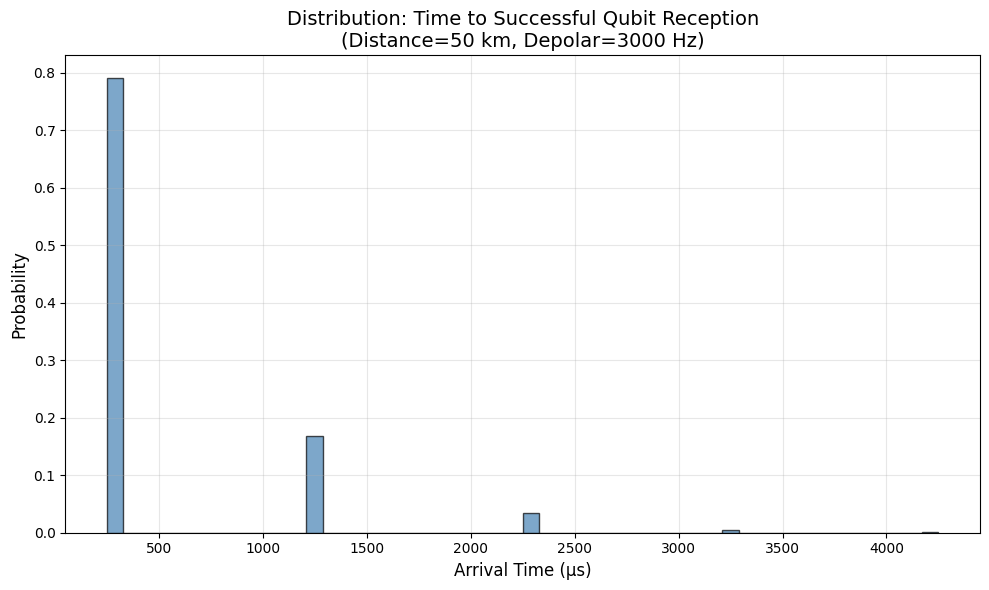

In [13]:
# Plot PMF of arrival times

plt.figure(figsize=(10, 6))
plt.hist(
    arrival_times,
    bins=50,
    density=False,  # Change to False
    weights=[1 / len(arrival_times)] * len(arrival_times),  # Normalize to probability
    alpha=0.7,
    edgecolor="black",
    color="steelblue",
)
plt.xlabel("Arrival Time (μs)", fontsize=12)
plt.ylabel("Probability", fontsize=12)  # Changed from "Probability Density"
plt.title(
    f"Distribution: Time to Successful Qubit Reception\n(Distance={distance} km, Depolar={depolar_freq} Hz)",
    fontsize=14,
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

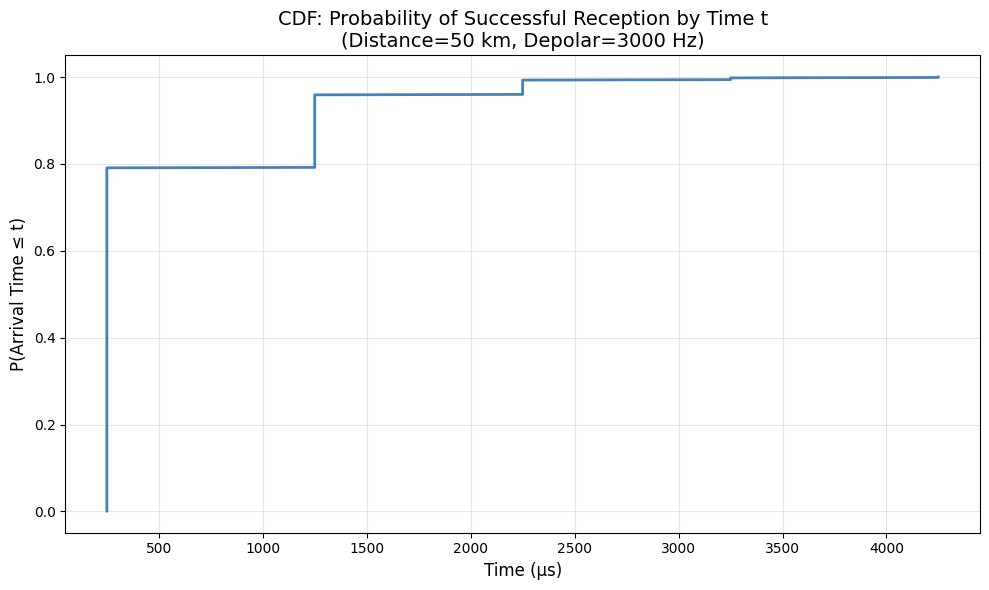

In [14]:
# Sort arrival times
arrival_times_sorted = sorted(arrival_times)
n = len(arrival_times_sorted)

# Calculate empirical CDF: P(T <= t)
probabilities = np.arange(1, n+1) / n

plt.figure(figsize=(10, 6))
plt.plot(arrival_times_sorted, probabilities, linewidth=2, color='steelblue')
plt.xlabel('Time (μs)', fontsize=12)
plt.ylabel('P(Arrival Time ≤ t)', fontsize=12)
plt.title(f'CDF: Probability of Successful Reception by Time t\n(Distance={distance} km, Depolar={depolar_freq} Hz)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Add this diagnostic cell
print(f"Total results: {len(fidelities)}")
print(f"None values: {fidelities.count(None)}")
print(f"Zero values: {sum(1 for f in fidelities if f == 0.0)}")
print(f"Min fidelity (excluding 0): {min(f for f in fidelities if f > 0.0):.4f}")
print(f"Distribution:")
for i in range(0, 11):
    threshold = i / 10
    count = sum(1 for f in fidelities if f is not None and threshold <= f < threshold + 0.1)
    print(f"  {threshold:.1f} - {threshold+0.1:.1f}: {count}")

Total results: 1000
None values: 0
Zero values: 0
Min fidelity (excluding 0): 1.0000
Distribution:
  0.0 - 0.1: 0
  0.1 - 0.2: 0
  0.2 - 0.3: 0
  0.3 - 0.4: 0
  0.4 - 0.5: 0
  0.5 - 0.6: 0
  0.6 - 0.7: 0
  0.7 - 0.8: 0
  0.8 - 0.9: 0
  0.9 - 1.0: 0
  1.0 - 1.1: 1000


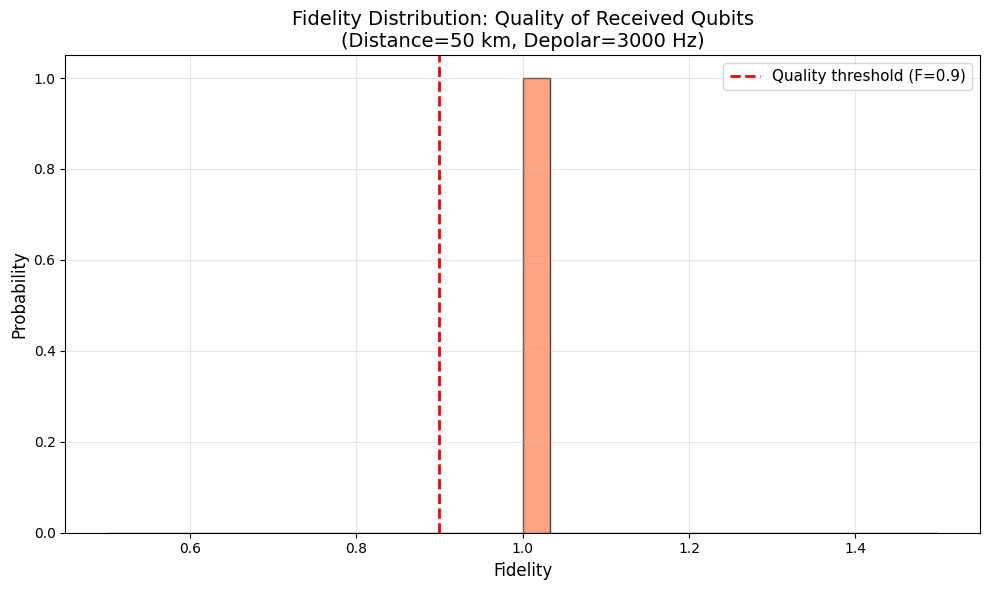

In [16]:
# Plot fidelity distribution
plt.figure(figsize=(10, 6))
plt.hist(
    fidelities,
    bins=30,
    density=False,
    weights=[1 / len(fidelities)] * len(fidelities),  # Normalize to probability
    alpha=0.7,
    edgecolor="black",
    color="coral",
)
plt.axvline(x=0.9, color='red', linestyle='--', linewidth=2, label='Quality threshold (F=0.9)')
plt.xlabel("Fidelity", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title(
    f"Fidelity Distribution: Quality of Received Qubits\n(Distance={distance} km, Depolar={depolar_freq} Hz)",
    fontsize=14,
)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()